# Quick start

In [3]:
import rectanglepy as rectangle
import pandas as pd
from anndata import AnnData, read_h5ad
import matplotlib.pyplot as plt

## Creating the input data

The tutorial data set contains single-cell RNA-seq counts as a pandas DataFrame, with the cell type annotations as a pandas Series.

The scRNA-seq data must come in the form of unnormalized gene counts, together with the associated cell-type annotations for the cell types of interest. The bulk RNA-seq data should be normalized as transcripts per million (TPM) –or counts per millions (CPM) in case of tag-based spatial transcriptomics. The gene nomenclature used for the single-cell and bulk datasets must match (e.g., gene synonyms) to provide meaningful results.

To see an example dataset, we can load the (small) tutorial data provided by Rectangle:

In [4]:
sc_counts, annotations, bulks  = rectangle.load_tutorial_data()

The tutorial data set contains (scRNA-seq data counts as a pandas DataFrame (cell by genes), with the cell-type annotations as a pandas Series (cell-type label for every cell ID).

In [12]:
sc_counts[['FCGR3A', 'RPL5', 'SF3B4','S100A10', 'ZBTB7B']].head()

,FCGR3A,RPL5,SF3B4,S100A10,ZBTB7B
E2L4_GATGCTACAGGCACAA,37,23,0,10,0
L5_AACAACCAGGAACTAT,0,15,0,12,2
L5_TCCTTCTGTACTCCGG,0,5,0,1,0
L2_GCCCGAACACGTATAC,0,15,1,12,1
E2L2_ATGCATGTCACACCCT,0,24,1,18,3


In [12]:
annotations.head()

E2L4_GATGCTACAGGCACAA    Monocytes
L5_AACAACCAGGAACTAT      Monocytes
L5_TCCTTCTGTACTCCGG      Monocytes
L2_GCCCGAACACGTATAC      Monocytes
E2L2_ATGCATGTCACACCCT    Monocytes
Name: 0, dtype: object

And the bulk RNA-seq data as a pandas DataFrame,
where the index is the sample ID and the columns are the genes.

In [18]:
bulks[['FCGR3A', 'RPL5', 'SF3B4','S100A10', 'ZBTB7B']].head()

,FCGR3A,RPL5,SF3B4,S100A10,ZBTB7B
pbmc_1,145.144880,2505.165434,78.708398,415.135,49.318210
pbmc_10,137.999249,2296.208027,79.041928,475.642,53.047700
pbmc_12,456.966440,2544.939500,74.853167,443.532,45.043961


The count dataframe with its annotations can be easily convert into an AnnData object.


In [4]:
sc_adata = AnnData(sc_counts, obs=annotations.to_frame(name="cell_type"))

## Single-step deconvolution

To deconvolute the bulk data in a single step, use the “rectangle()” function. This method returns the results of the signature-building step (signature_result) and a tuple with the estimated cell type proportions for every sample of the deconvolved bulk dataset (estimations)

In [ ]:
estimations, signature_result = rectangle.rectangle(sc_adata, bulks)

The rectangle method returns two objects:
1. `estimations`: a pandas DataFrame with the estimated cell type proportions for each bulk sample.
2. `signature_result`: a [`RectangleSignatureResult`](../generated/rectanglepy.pp.RectangleSignatureResult.rst) object containing  additional information about the signature and the unknown content.


In [6]:
estimations

,B cells,ILC,Monocytes,NK cells,Plasma cells,Platelet,T cells CD4 conv,T cells CD8,Tregs,mDC,pDC,Unknown
pbmc_1,0.090739,0.011386,0.229843,0.022667,0.005956,0.004898,2.833039e-02,0.162392,0.416964,0.024425,0.002401,0.000000
pbmc_10,0.110518,0.016910,0.297931,0.016344,0.000659,0.021996,8.220139e-18,0.118382,0.391830,0.020750,0.004678,0.000000
pbmc_12,0.071532,0.007335,0.225517,0.101075,0.003095,0.018637,0.000000e+00,0.275009,0.256503,0.010054,0.002985,0.028258


In [7]:
signature_result

## 2-step deconvolution

Rectangle can also be run in two steps, first creating the signature and then deconvolving the bulk data.

**1. Create Signature result**

In [ ]:
signature_result = rectangle.pp.build_rectangle_signatures(sc_adata, bulks=bulks)

This creates a [`RectangleSignatureResult`](../generated/rectanglepy.pp.RectangleSignatureResult.rst) object.

**2. Deconvolve bulk data**

We can then use the signature result to deconvolve the bulk data. This is done using the `deconvolution` method of the `RectangleSignatureResult` object, which should be fed with the signature_result object obtained at the previous step and the bulk dataset to be deconvolved

In [ ]:
estimations, _ = rectangle.tl.deconvolution(signature_result, bulks)

This call returns a pandas DataFrame with the estimated cell type proportions.

In [12]:
estimations

,B cells,ILC,Monocytes,NK cells,Plasma cells,Platelet,T cells CD4 conv,T cells CD8,Tregs,mDC,pDC,Unknown
pbmc_1,0.090739,0.011386,0.229843,0.022667,0.005956,0.004898,2.833039e-02,0.162392,0.416964,0.024425,0.002401,0.000000
pbmc_10,0.110518,0.016910,0.297931,0.016344,0.000659,0.021996,8.220139e-18,0.118382,0.391830,0.020750,0.004678,0.000000
pbmc_12,0.071532,0.007335,0.225517,0.101075,0.003095,0.018637,0.000000e+00,0.275009,0.256503,0.010054,0.002985,0.028258


# Bulk RNA-seq deconvolution

To apply Rectangle to a more meaningful use case, we will perform the deconvolution of 9 bulk RNA-seq samples from blood-cell mixtures generated in the {cite}`Finotello2019` study.
We can access this dataset from [deconvData](https://figshare.com/articles/dataset/Validation_real/25347757?file=44877523){cite}`Dietrich2024`


In [19]:
url = "https://figshare.com/ndownloader/files/44877523"
bulks_fino = pd.read_csv(url, index_col=0)
bulks_fino.T[['LYZ', 'CD14', 'FCGR3A', 'CD8A', 'CD3D']].head()

,LYZ,CD14,FCGR3A,CD8A,CD3D
pbmc_1,7912.41,645.8500,145.144880,123.580148,357.85446
pbmc_10,9331.48,800.9088,137.999249,99.817693,258.58275
pbmc_12,9506.39,512.9779,456.966440,179.161160,328.40886
pbmc_2,6048.82,505.6502,158.455478,87.202916,320.96350
pbmc_4,3547.27,288.5666,314.124590,175.999580,267.81102


To train rectangle and build the signature matrix, we will use single-cell dataset human peripheral blood mononuclear cells (PBMC) profiled with the CITE-seq technology in the Hao et al. study {cite}`Hao2021`. We will use a reduced and reannotated version of this dataset which is accessible through [deconvData](https://figshare.com/articles/dataset/Training_sc/25348051?file=56063936)


In [11]:
# the files are originaly in an rds format,
# we skip the conversion step here and load an AnnData object directly
haoSub_adata = read_h5ad("../data/haoSub_adata.h5ad")
haoSub_adata

AnnData object with n_obs × n_vars = 14744 × 24049
    obs: 'cell_type'

We can now use the `rectangle` method to deconvolute the bulk data guided by the single-cell expression profiles and annotations using just a single command.

In [ ]:
estimations, signature_result = rectangle.rectangle(haoSub_adata, bulks_fino.T)

The estimated cell-type fractions can be visualized in Python as a stacked barplot using matplotlib:

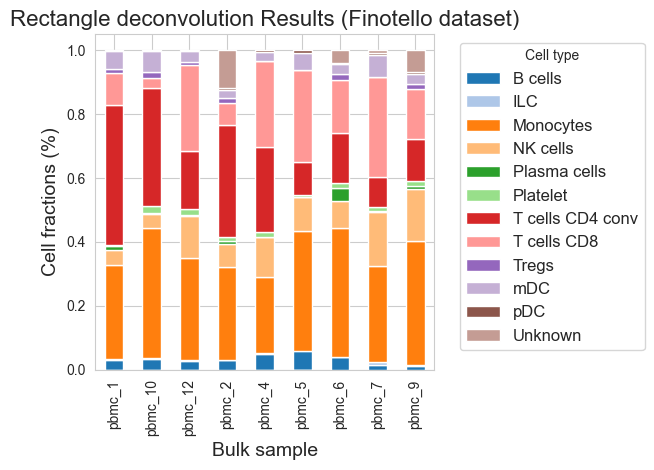

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
colors = plt.get_cmap('tab20').colors  # More distinct colors
estimations.plot(kind='bar', stacked=True, ax=ax, color=colors)
ax.set_title('Rectangle deconvolution Results (Finotello dataset)', fontsize=16)
ax.set_ylabel('Cell fractions (%)', fontsize=14)
ax.set_xlabel('Bulk sample', fontsize=14)
ax.legend(title='Cell type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

The Finotello dataset also provides ground-truth cell fractions obtained via fluorescence-activated cell sorting (FACS) from all the analyzed bulk samples, which can be used to validate Rectangle estimates.

So let us further explore the  estimation performance by plotting the estimated cell type proportions against the true cell type proportions we can again obtain from [deconvData](https://figshare.com/articles/dataset/Validation_real/25347757?file=44877526).


In [28]:
url = "https://figshare.com/ndownloader/files/44877526"
finotello_true = pd.read_csv(url, index_col=0).T
# rename the columns to match the cell types in the estimations
finotello_true.columns = ["NK cells", 'B cells', 'Tregs', 'mDC', 'Monocytes', 'Neutrophils', 'T cells CD8',
                         'T cells CD4 conv', 'Other']

First, we need to do some data wrangling to make the data compatible.


In [29]:
# funtion to match the dataframes by index and columns
# and sort them by index and columns
def match_dfs(df1, df2):
    common_rows = df1.index.intersection(df2.index)
    common_cols = df1.columns.intersection(df2.columns)
    df1_matched = df1.loc[common_rows, common_cols].sort_index().sort_index(axis=1)
    df2_matched = df2.loc[common_rows, common_cols].sort_index().sort_index(axis=1)
    return df1_matched, df2_matched

# function to create a dataframe for evaluation
# it takes the expected and estimated dataframes and returns a melted dataframe
def create_evaluation_df(expected_df, estimated_df):
    evaluation_df = expected_df.T.melt()
    estimated_df_e = estimated_df.T.melt()
    evaluation_df['result'] = estimated_df_e['value']
    evaluation_df.columns = ['Cell type','True Fractions' , 'Estimated Fractions']
    return evaluation_df

true_m, finotello_m = match_dfs(finotello_true.T, estimations.T)
true_m = true_m.sort_index(key=lambda x: x.str.lower())
finotello_m = finotello_m.sort_index(key=lambda x: x.str.lower())

evaluation_df = create_evaluation_df(true_m, finotello_m)


Next, we quantitatively compare Rectangle estimates to the ground-truth cell fractions using Pearson correlation (r) and root-mean square error (RMSE), as well as cell-fraction scatter plots:

<Axes: xlabel='True Fractions', ylabel='Estimated Fractions'>

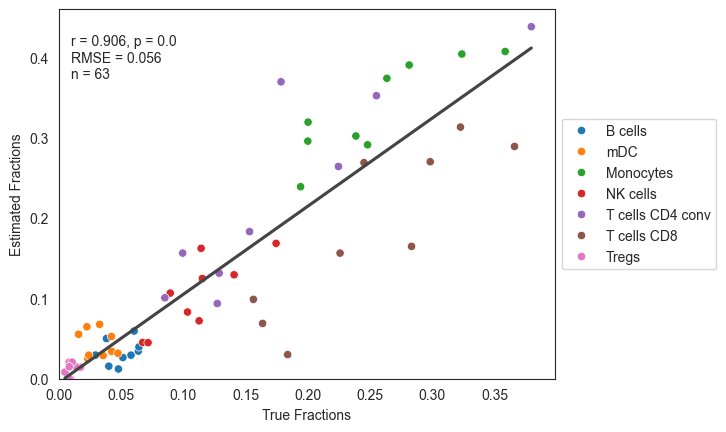

In [27]:
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns

def evaulate_total_df(df):
    rsme_total = np.sqrt(np.mean((df['Estimated Fractions'] - df['True Fractions']) ** 2))
    r_value_total, p_value_total =  pearsonr(df['Estimated Fractions'], df['True Fractions'])
    return rsme_total, r_value_total, p_value_total

rsme_finotello_rectangle, r_finotello_rectangle, p_finotello_rectangle = evaulate_total_df(evaluation_df)

def create_scatter_plot_total(df, rsme, p_value, r_value, title="Total", y_axis_label="Estimated Fractions", x_axis_label="True Fractions", hue="Cell type"):
    sns.set_style("white")
    g = sns.scatterplot(x="True Fractions", y="Estimated Fractions",hue=hue, data=df)
    sns.regplot(x="True Fractions", y="Estimated Fractions", data=df, scatter=False, color='#444444', ci=None)
    text = f"r = {round(r_value, 3)}, p = {round(p_value, 10)} \nRMSE = {round(rsme, 3)}\nn = {len(df)}"
    g.set(xlabel=x_axis_label, ylabel=y_axis_label)
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    g.annotate(text, xy=(0.01, 0.95), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                ha="left", va="top")
    g.set_xlim(0, g.get_xlim()[1])
    g.set_ylim(0, g.get_ylim()[1])
    return g

rsme_finotello_rectangle, r_finotello_rectangle, p_finotello_rectangle = evaulate_total_df(evaluation_df)
create_scatter_plot_total(evaluation_df, rsme_finotello_rectangle, p_finotello_rectangle, r_finotello_rectangle)

# Spatial deconvolution

Rectangle can be also effectively applied to spot-based spatial transcriptomics data, seamlessly integrating with the `spatialdata` package.
See the [spatialdata documentation](https://spatialdata.scverse.org/en/stable/index.html) for more details.


To showcase an example of spatial deconvolution with Rectangle, we will consider the spatial transcriptomics dataset generated from the human dorsolateral prefrontal cortex generated with the 10x Genomics Visium platform{cite}`Maynard2021`.
 In particular, we will focus on the '151673' slide, which can be downloaded from here:
[https://spatial-dlpfc.s3.us-east-2.amazonaws.com/h5/151673_filtered_feature_bc_matrix.h5](https://spatial-dlpfc.s3.us-east-2.amazonaws.com/h5/151673_filtered_feature_bc_matrix.h5)

In [ ]:
import spatialdata
import spatialdata_io

s_data = spatialdata_io.visium(path='../data', dataset_id='151673',scalefactors_file='scalefactors_json.json', tissue_positions_file='tissue_positions.csv', counts_file='151673_filtered_feature_bc_matrix.h5')


To train Rectangle and build the signature matrix, we will use the single-nuclei RNA-se (snRNA-seq) “M1” dataset from the Allen Brain Atlas{cite}`Bakken2021`. The single-cell expression profiles (gene counts) and asscciated annotations can be downloaded from [M1 Allen Brain atlas](https://portal.brain-map.org/atlases-and-data/rnaseq/human-m1-10x)

In [ ]:
counts = pd.read_csv('../data/human_m1/matrix.csv', index_col=0)
counts = counts.astype(int)
metadata = pd.read_csv('../data/human_m1/metadata.csv', index_col=0)
annotations = metadata['cell_type_alias_label']


We do a simple preprocessing of the annotations to group the cell types into coarser cell types:

In [ ]:
# remove anything after the second space(word)
annotations = annotations.str.split(' ', n=2).str[:2].str.join(' ')
# remove anything afert first minus
annotations = annotations.str.split('-', n=1).str[0]

We can run Rectangle on the spatial data using the `rectangle method, by using the ‘table’ object of the `SpatialData` object. As the spatial expression data is summarized as raw gene counts, we will first convert it to CPM.

In [ ]:
adata = AnnData(counts, obs=annotations.to_frame(name='cell_type'))

data_table = s_data['table']
bulks = data_table.to_df()
# Convert bulks from counts to CPM
bulks_cpm = bulks.div(bulks.sum(axis=1), axis=0) * 1e6


In [ ]:
estimations, signature_result = rectangle.rectangle(adata, bulks_cpm)


We can add our estimations to the spatial data by creating a new `AnnData` object from the estimations and adding it to the `SpatialData` object.

In [ ]:
from spatialdata.models import TableModel

table_data = AnnData(estimations)
adata_for_sdata = TableModel.parse(table_data)

adata_for_sdata.uns["spatialdata_attrs"] = {
    "region": "spots",
    "region_key": "region",
    "instance_key": "spot_id",
}

adata_for_sdata.obs["region"] = pd.Categorical(["spots"] * len(adata_for_sdata))
adata_for_sdata.obs["spot_id"] = s_data.tables.data['table'].obs["spot_id"]

s_data.tables["rectangle_results"] = adata_for_sdata